<h1 align="center">Advanced Image Processing and Analysis</h1>
<h3 align="center">ECE 4438B/ECE 9022/ECE 9202B/BIOMED 9519B/BIOPHYS 9519B/CAMI 9519B</h3>
<h4 align="center"><a href="mailto:echen29@uwo.ca?subject=Day 20: Manual Initialization"> Elvis Chen, PhD, LL</a></h4>
<h4 align="center">Day 20, March 19, 2019</h4>

#### Manual initialization

When all else fails, a human in the loop will almost always be able to robustly initialize the registration.

In the example below we identify corresponding points to compute an initial rigid transformation. 

**Note**: There is no correspondence between the fiducial markers on the phantom.

In [1]:
import SimpleITK as sitk
from ipywidgets import interact, fixed
%run update_path_to_download_script
from downloaddata import fetch_data as fdata
import gui
import registration_gui as rgui
import registration_utilities as ru
%matplotlib notebook

import numpy as np
import os
OUTPUT_DIR = 'output'

In [2]:
data_directory = os.path.dirname(fdata("CIRS057A_MR_CT_DICOM/readme.txt"))

fixed_series_ID = "1.2.840.113619.2.290.3.3233817346.783.1399004564.515"
moving_series_ID = "1.3.12.2.1107.5.2.18.41548.30000014030519285935000000933"

reader = sitk.ImageSeriesReader()
fixed_image = sitk.ReadImage(reader.GetGDCMSeriesFileNames(data_directory, fixed_series_ID), sitk.sitkFloat32)
moving_image = sitk.ReadImage(reader.GetGDCMSeriesFileNames(data_directory, moving_series_ID), sitk.sitkFloat32)

# To provide a reasonable display we need to window/level the images. By default we could have used the intensity
# ranges found in the images [SimpleITK's StatisticsImageFilter], but these are not the best values for viewing.
# Using an external viewer we identified the following settings.
fixed_intensity_range = (-1183,544)
moving_intensity_range = (0,355)

Fetching CIRS057A_MR_CT_DICOM/readme.txt


#### Manual initialization

When all else fails, a human in the loop will almost always be able to robustly initialize the registration.

In the example below we identify corresponding points to compute an initial rigid transformation. 

**Note**: There is no correspondence between the fiducial markers on the phantom.

In [3]:
ct_window_level = [1727,-320]
mr_window_level = [355,178]

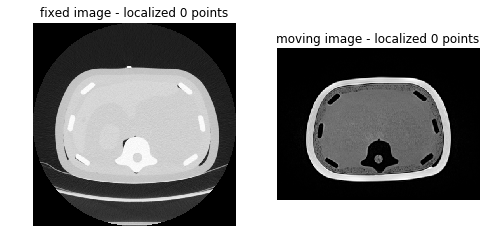

In [4]:
point_acquisition_interface = gui.RegistrationPointDataAquisition(fixed_image, moving_image, figure_size=(8,4), fixed_window_level=ct_window_level, moving_window_level=mr_window_level);

In [5]:
# Get the manually specified points and compute the transformation.

fixed_image_points, moving_image_points = point_acquisition_interface.get_points()

# Previously localized points (here so that the testing passes):
fixed_image_points = [(24.062587103074605, 14.594981536981521, -58.75), (6.178716135332678, 53.93949766601378, -58.75), (74.14383149714774, -69.04462737237648, -76.25), (109.74899278747029, -14.905272533666817, -76.25)]
moving_image_points = [(4.358707846364581, 60.46357110706131, -71.53120422363281), (24.09010295252645, 98.21840981673873, -71.53120422363281), (-52.11888008581127, -26.57984635768439, -58.53120422363281), (-87.46150681392184, 28.73904765153219, -58.53120422363281)]

fixed_image_points_flat = [c for p in fixed_image_points for c in p]        
moving_image_points_flat = [c for p in moving_image_points for c in p]
initial_transformation = sitk.LandmarkBasedTransformInitializer(sitk.VersorRigid3DTransform(), 
                                                                fixed_image_points_flat, 
                                                                moving_image_points_flat)

In [6]:
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, estimateLearningRate=registration_method.Once)
registration_method.SetOptimizerScalesFromPhysicalShift() 
registration_method.SetInitialTransform(initial_transformation)
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas = [2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

final_transform = registration_method.Execute(fixed_image, moving_image)
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

Final metric value: -0.10059914325478544
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 34.


Visually evaluate our results:

In [7]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(ru.display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]), alpha=(0.0,1.0,0.05), 
         image1 = fixed(sitk.IntensityWindowing(fixed_image, fixed_intensity_range[0], fixed_intensity_range[1])), 
         image2=fixed(sitk.IntensityWindowing(moving_resampled, moving_intensity_range[0], moving_intensity_range[1])));

interactive(children=(IntSlider(value=141, description='image_z', max=283), FloatSlider(value=0.5, description…